# sklearn - low level api

In [86]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score

# import data
df = pd.read_csv('data/online_shoppers_intention.csv')

# drop target variable
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# encode the data

le = LabelEncoder()

category_columns = ['Month', 'VisitorType']

X[category_columns] = X[category_columns].apply(lambda col: le.fit_transform(col))

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# convert the data to a dmatrix and set labels
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# define the hyper-parameters

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    # 'n_estimators': 100 -- doesnt work
}

# train the model
model = xgb.train(params, dtrain)

# make predictions on the test set
predictions = model.predict(dtest)

# Evaluate the model's performance using AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)

auc = roc_auc_score(y_test, predictions)
print("AUC: {:.4f}".format(auc))

AUC: 0.9205


# High level api

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
AUC: 0.7689
Accuracy: 0.8921
Precision: 0.7164
Recall: 0.5839
F1 score: 0.6434


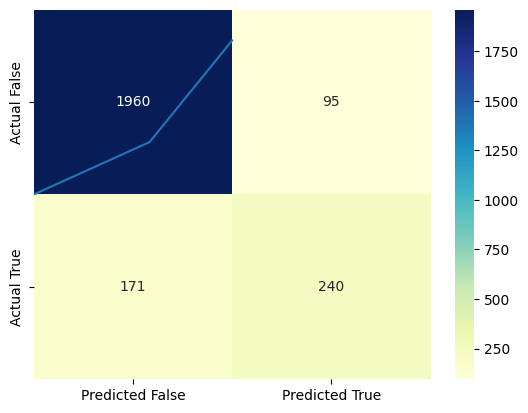

In [15]:
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
import json
import random
import yaml

# Load the configuration from the YAML file
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

# Access the values in the dictionary
project_name = config["project"]
xgboost_params = config["xgboost"]
bigquery_creds = config["bigquery"]

# import data
df = pd.read_csv('data/online_shoppers_intention.csv')

# drop target variable
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# encode the data
le = LabelEncoder()

category_columns = ['Month', 'VisitorType']

X[category_columns] = X[category_columns].apply(lambda col: le.fit_transform(col))

# Impute missing values in the category columns using the mean
imputer = SimpleImputer(strategy='mean')

contain_nan_columns = ['VisitorType']

X[contain_nan_columns] = imputer.fit_transform(X[contain_nan_columns])


# Scale the data using the RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(X)


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


# Create an XGBClassifier object
#model = xgb.XGBClassifier(objective="binary:logistic", max_depth=3, learning_rate=0.1, n_estimators=100)
model = xgb.XGBClassifier(objective="binary:logistic")

# Extract the parameter grid from the configuration
param_grid = config["xgboost"]["param_grid"]

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="roc_auc")

# Fit the model
grid_search.fit(X_train, y_train)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: {}".format(grid_search.best_params_))

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)


# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model's performance using AUC
auc = roc_auc_score(y_test, predictions)
print("AUC: {:.4f}".format(auc))

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# Calculate the precision of the model
precision = precision_score(y_test, predictions)

# Calculate the recall of the model
recall = recall_score(y_test, predictions)

# Calculate the F1 score of the model
f1 = f1_score(y_test, predictions)

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 score: {:.4f}".format(f1))

# Calculate the F1 score, precision, and recall values for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predictions, pos_label=1)

# Create a dataframe with the F1 score, precision, and recall values
scores_df = pd.DataFrame({"precision": precision, "recall": recall})

# Plot the precision and recall values
sns.lineplot(x="recall", y="precision", data=scores_df)
# plt.show() - interactive mode off

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Convert the confusion matrix to a dataframe
cm_df = pd.DataFrame(cm, index=["Actual False", "Actual True"], columns=["Predicted False", "Predicted True"])


# Convert the values in the confusion matrix to integers
cm_df = cm_df.astype(int)

# Plot the confusion matrix using seaborn
sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")

# Save the plot as a PNG image
plt.savefig("artifacts/heatmap.png")

params = model.get_params()

# Generate a random 5-digit number
rand_number = random.randint(10000, 99999)

# Save model parameters to run
with open(f"artifacts/params_run_{rand_number}.json", "w") as f:
    # Write the dictionary to the file as JSON
    json.dump(params, f)
    

(12330, 18)


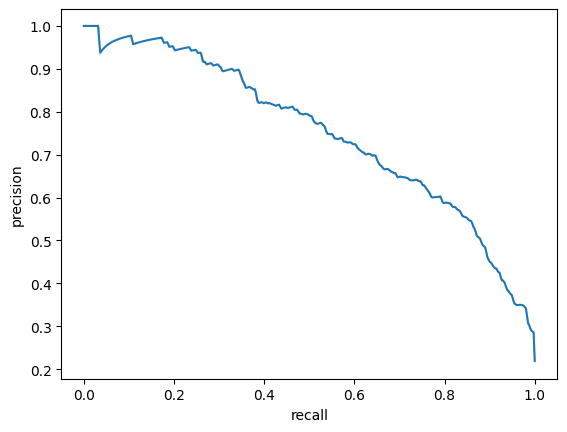

<Figure size 640x480 with 0 Axes>

In [10]:
import pandas as pd
import xgboost as xgb
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score
import matplotlib.pyplot as plt

# import data
df = pd.read_csv('data/online_shoppers_intention.csv')

print(df.shape)

# drop target variable
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# encode the data
le = LabelEncoder()

category_columns = ['Month', 'VisitorType']

X[category_columns] = X[category_columns].apply(lambda col: le.fit_transform(col))

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Create an XGBClassifier object
model = xgb.XGBClassifier(objective="binary:logistic", max_depth=3, learning_rate=0.1, n_estimators=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict_proba(X_test)[:, 1]

# Calculate the F1 score, precision, and recall values for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predictions, pos_label=1)

# Create a dataframe with the F1 score, precision, and recall values
scores_df = pd.DataFrame({"precision": precision, "recall": recall})

# # Plot the F1 score, precision, and recall values
# sns.lineplot(x="recall", y="precision", data=scores_df, label="Precision")
# sns.lineplot(x="recall", y="recall", data=scores_df, label="Recall")
# plt.show()

# Plot the precision and recall values
sns.lineplot(x="recall", y="precision", data=scores_df)
plt.show()

plt.savefig('artifacts/precision_recall_curve.png')

In [12]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv("data.csv")

# Split the data into features and target
X = data.drop("outcome", axis=1)
y = data["outcome"]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data into DMatrix format, which is a data structure that XGBoost can efficiently work with
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for the model
params = {
    "objective": "binary:logistic",  # The loss function to be optimized
    "max_depth": 3,  # The maximum depth of the trees
    "learning_rate": 0.1,  # The learning rate
    "n_estimators": 100,  # The number of trees to build
}

# Train the model
model = xgb.train(params, dtrain)

# Make predictions on the test set
predictions = model.predict(dtest)

# Evaluate the model's performance using AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print("AUC: {:.4f}".format(auc))



FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder object to the data
le.fit(X["Month"])

# Transform the data using the LabelEncoder object
X["Month"] = le.transform(X["Month"])

# Repeat the process for the other categorical column
le.fit(X["VisitorType"])
X["VisitorType"] = le.transform(X["VisitorType"])



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Select the categorical columns
categorical_cols = ["Month", "VisitorType"]

# Fit the LabelEncoder object to the categorical columns
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))


In [28]:
help(le.fit_transform)

Help on method fit_transform in module sklearn.preprocessing._label:

fit_transform(y) method of sklearn.preprocessing._label.LabelEncoder instance
    Fit label encoder and return encoded labels.
    
    Parameters
    ----------
    y : array-like of shape (n_samples,)
        Target values.
    
    Returns
    -------
    y : array-like of shape (n_samples,)
        Encoded labels.



In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# Calculate the precision of the model
precision = precision_score(y_test, predictions)

# Calculate the recall of the model
recall = recall_score(y_test, predictions)

# Calculate the F1 score of the model
f1 = f1_score(y_test, predictions)

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 score: {:.4f}".format(f1))

Accuracy: 0.8929
Precision: 0.7363
Recall: 0.5572
F1 score: 0.6343
